# Bit Flip Problem with Reinforcement Learning

## Using AWS SageMaker for RL

AWS SageMaker allows you to train your RL agents in cloud machines using docker containers. You do not have to worry about setting up your machines with the RL toolkits and deep learning frameworks. You can easily switch between many different machines setup for you, including powerful GPU machines that give a big speedup. You can also choose to use multiple machines in a cluster to further speedup training, often necessary for production level loads.

### Prerequisites 

#### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [1]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
from IPython.display import HTML
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

#### Settings

You can run this notebook from your local host or from a SageMaker notebook instance. In both of these scenarios, you can run the following in either local or SageMaker modes. The local mode uses the SageMaker Python SDK to run your code in a local container before deploying to SageMaker. This can speed up iterative testing and debugging while using the same familiar Python SDK interface. You just need to set local_mode = True.

In [2]:
# run in local mode?
local_mode = False

env_type = 'simple-corridor'

# create unique job name 
job_name_prefix = 'rl-' + env_type

# S3 bucket
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-609956480270


S3 bucket path: s3://sagemaker-us-east-1-609956480270/


#### Install docker for `local` mode

In order to work in `local` mode, you need to have docker installed. When running from you local machine, please make sure that you have docker or docker-compose (for local CPU machines) and nvidia-docker (for local GPU machines) installed. Alternatively, when running from a SageMaker notebook instance, you can simply run the following script to install dependenceis.

Note, you can only run a single local notebook at one time.

In [3]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash common/setup.sh

The user has root access.
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


#### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [4]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::609956480270:role/service-role/AmazonSageMaker-ExecutionRole-20181128T031491


#### Setup the environment

The environment is defined in a Python file called “bit_flip_env.py” and the file is uploaded on /src directory. 

The environment also implements the init(), step(), reset() and render() functions that describe how the environment behaves. This is consistent with Open AI Gym interfaces for defining an environment. 


1. Init() - initialize the environment in a pre-defined state
2. Step() - take an action on the environment
3. reset()- restart the environment on a new episode
4. render() - get a rendered image of the environment in its current state

#### Configure the presets for RL algorithm 

The presets that configure the RL training jobs are defined in the “preset-tsp-easy.py” file which is also uploaded on the /src directory. Using the preset file, you can define agent parameters to select the specific agent algorithm. You can also set the environment parameters, define the schedule and visualization parameters, and define the graph manager. The schedule presets will define the number of heat up steps, periodic evaluation steps, training steps between evaluations.

These can be overridden at runtime by specifying the RLCOACH_PRESET hyperparameter. Additionally, it can be used to define custom hyperparameters. 

In [5]:
!pygmentize src/preset-simple-corridor.py

from rl_coach.agents.clipped_ppo_agent import ClippedPPOAgentParameters
from rl_coach.environments.gym_environment import GymVectorEnvironment
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import SimpleSchedule
from rl_coach.core_types import *
#from rl_coach.environments.environment import SelectedPhaseOnlyDumpMethod, MaxDumpMethod
from rl_coach import logger
from rl_coach.base_parameters import TaskParameters
from rl_coach.base_parameters import VisualizationParameters
from rl_coach.architectures.embedder_parameters import InputEmbedderParameters

################
#  Environment #
################

env_params = GymVectorEnvironment(level='simple_corridor_env:SimpleCorridor')

#########
# Agent #
#########

agent_params = ClippedPPOAgentParameters()

#################
# Visualization #
#################

#env_params.frame_skip = 5 #to make sure the gifs work without skipping steps

vis_params = VisualizationPa

#### Write the Training Code 

The training code is written in the file “train-coach.py” which is uploaded in the /src directory. 
First import the environment files and the preset files, and then define the main() function. 

In [6]:
!pygmentize src/train-coach-simple-corridor.py

from sagemaker_rl.coach_launcher import SageMakerCoachPresetLauncher


class MyLauncher(SageMakerCoachPresetLauncher):

    def default_preset_name(self):
        """This points to a .py file that configures everything about the RL job.
        It can be overridden at runtime by specifying the RLCOACH_PRESET hyperparameter.
        """
        return 'preset-simple-corridor'

    def map_hyperparameter(self, name, value):
        """Here we configure some shortcut names for hyperparameters that we expect to use frequently.
        Essentially anything in the preset file can be overridden through a hyperparameter with a name 
        like "rl.agent_params.algorithm.etc".  
        """
        # maps from alias (key) to fully qualified coach parameter (value)
        mapping = {
                      "discount": "rl.agent_params.algorithm.discount",
                      "evaluation_episodes": "rl.evaluation_steps:EnvironmentEpisodes",
                      "improve_steps": "rl.improve_s

### Train the RL model using the Python SDK Script mode

If you are using local mode, the training will run on the notebook instance. When using SageMaker for training, you can select a GPU or CPU instance. The RLEstimator is used for training RL jobs. 

1. Specify the source directory where the environment, presets and training code is uploaded.
2. Specify the entry point as the training code 
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container. 
4. Define the training parameters such as the instance count, job name, S3 path for output and job name. 
5. Specify the hyperparameters for the RL agent algorithm. The RLCOACH_PRESET or the RLRAY_PRESET can be used to specify the RL agent algorithm you want to use. 
6. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks. 

In [9]:
%%time

if local_mode:
    instance_type = 'local'
else:
    instance_type = "ml.m4.4xlarge"
    
estimator = RLEstimator(entry_point="train-coach-simple-corridor.py",
                        source_dir='src',
                        dependencies = ["common/sagemaker_rl"],
                        toolkit=RLToolkit.COACH,
                        toolkit_version='0.11',
                        framework=RLFramework.TENSORFLOW,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        hyperparameters = {
                          #expected run time 12 mins for TSP Easy  
                          "RLCOACH_PRESET": "preset-" + env_type, 
                        }
                    )

estimator.fit(wait=local_mode)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-609956480270
INFO:sagemaker:Creating training-job with name: rl-simple-corridor-2019-06-21-22-16-06-261


Creating tmpynrz7k5n_algo-1-sz4gh_1 ... 
Attaching to tmpynrz7k5n_algo-1-sz4gh_12mdone
algo-1-sz4gh_1  | 2019-06-21 22:16:09,507 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-sz4gh_1  | 2019-06-21 22:16:09,513 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-sz4gh_1  | 2019-06-21 22:16:09,641 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-sz4gh_1  | 2019-06-21 22:16:09,662 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-sz4gh_1  | 2019-06-21 22:16:09,675 sagemaker-containers INFO     Invoking user script
algo-1-sz4gh_1  | 
algo-1-sz4gh_1  | Training Env:
algo-1-sz4gh_1  | 
algo-1-sz4gh_1  | {
algo-1-sz4gh_1  |     "additional_framework_parameters": {
algo-1-sz4gh_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-sz4gh_1  |     },
algo-1-sz4gh_1  |     "channel_input_dirs": {},
algo-1-sz4gh_1  |     "current_host": "algo-1-s

algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=17, Total reward=1, Steps=318, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=18, Total reward=1, Steps=336, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=19, Total reward=1, Steps=341, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=20, Total reward=1, Steps=351, Training iteration=0
algo-1-sz4gh_1  | ## agent: Starting evaluation phase
algo-1-sz4gh_1  | Testing> Name=main_level/agent, Worker=0, Episode=20, Total reward=-1, Steps=351, Training iteration=0
algo-1-sz4gh_1  | Testing> Name=main_level/agent, Worker=0, Episode=20, Total reward=-1, Steps=351, Training iteration=0
algo-1-sz4gh_1  | Testing> Name=main_level/agent, Worker=0, Episode=20, Total reward=-1, Steps=351, Training iteration=0
algo-1-sz4gh_1  | Testing> Name=main_level/agent, Worker=0, Episode=20, Total reward=-1, Steps=351,

algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=63, Total reward=1, Steps=996, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=64, Total reward=1, Steps=1005, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=65, Total reward=1, Steps=1013, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=66, Total reward=1, Steps=1022, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=67, Total reward=1, Steps=1036, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=68, Total reward=1, Steps=1052, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=69, Total reward=1, Steps=1057, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=70, Total reward=1, Steps=1092, Training iteration=0
algo-1-sz4gh_1  | Trainin

algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=113, Total reward=1, Steps=1737, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=114, Total reward=1, Steps=1744, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=115, Total reward=1, Steps=1755, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=116, Total reward=1, Steps=1763, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=117, Total reward=1, Steps=1797, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=118, Total reward=1, Steps=1810, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=119, Total reward=1, Steps=1817, Training iteration=0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=120, Total reward=1, Steps=1860, Training iteration=0
algo-1-sz4gh_1  

algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=148, Total reward=1, Steps=2226, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=149, Total reward=1, Steps=2233, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=150, Total reward=1, Steps=2244, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=151, Total reward=1, Steps=2249, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=152, Total reward=1, Steps=2264, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=153, Total reward=1, Steps=2276, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=154, Total reward=1, Steps=2289, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=155, Total reward=1, Steps=2296, Training iteration=1
algo-1-sz4gh_1  

algo-1-sz4gh_1  | Testing> Name=main_level/agent, Worker=0, Episode=200, Total reward=1, Steps=2745, Training iteration=1
algo-1-sz4gh_1  | Testing> Name=main_level/agent, Worker=0, Episode=200, Total reward=1, Steps=2745, Training iteration=1
algo-1-sz4gh_1  | Testing> Name=main_level/agent, Worker=0, Episode=200, Total reward=1, Steps=2745, Training iteration=1
algo-1-sz4gh_1  | Testing> Name=main_level/agent, Worker=0, Episode=200, Total reward=1, Steps=2745, Training iteration=1
algo-1-sz4gh_1  | Testing> Name=main_level/agent, Worker=0, Episode=200, Total reward=1, Steps=2745, Training iteration=1
algo-1-sz4gh_1  | ## agent: Finished evaluation phase. Success rate = 0.0, Avg Total Reward = 1.0
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=201, Total reward=1, Steps=2752, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=202, Total reward=1, Steps=2766, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/ag

algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=247, Total reward=1, Steps=3148, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=248, Total reward=1, Steps=3156, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=249, Total reward=1, Steps=3166, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=250, Total reward=1, Steps=3173, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=251, Total reward=1, Steps=3181, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=252, Total reward=1, Steps=3190, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=253, Total reward=1, Steps=3201, Training iteration=1
algo-1-sz4gh_1  | Training> Name=main_level/agent, Worker=0, Episode=254, Total reward=1, Steps=3208, Training iteration=1
algo-1-sz4gh_1  

KeyboardInterrupt: 

### Store intermediate training output and model checkpoints 

The output from the training job above is stored on S3. The intermediate folder contains gifs and metadata of the training.

In [10]:
job_name=estimator._current_job_name
print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(s3_bucket,job_name)

if local_mode:
    output_tar_key = "{}/output.tar.gz".format(job_name)
else:
    output_tar_key = "{}/output/output.tar.gz".format(job_name)

intermediate_folder_key = "{}/output/intermediate".format(job_name)
output_url = "s3://{}/{}".format(s3_bucket, output_tar_key)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Output.tar.gz location: {}".format(output_url))
print("Intermediate folder path: {}".format(intermediate_url))
    
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Job name: rl-simple-corridor-2019-06-21-22-16-06-261
S3 job path: s3://sagemaker-us-east-1-609956480270/rl-simple-corridor-2019-06-21-22-16-06-261
Output.tar.gz location: s3://sagemaker-us-east-1-609956480270/rl-simple-corridor-2019-06-21-22-16-06-261/output.tar.gz
Intermediate folder path: s3://sagemaker-us-east-1-609956480270/rl-simple-corridor-2019-06-21-22-16-06-261/output/intermediate
Create local folder /tmp/rl-simple-corridor-2019-06-21-22-16-06-261


### Visualization

#### Comparing against a baseline policy

#### Plot metrics for training job
We can pull the reward metric of the training and plot it to see the performance of the model over time.

Waiting for s3://sagemaker-us-east-1-609956480270/rl-bit-flip-2019-06-21-21-33-25-639/output/intermediate/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv...


Text(0.5,0,'Episode #')

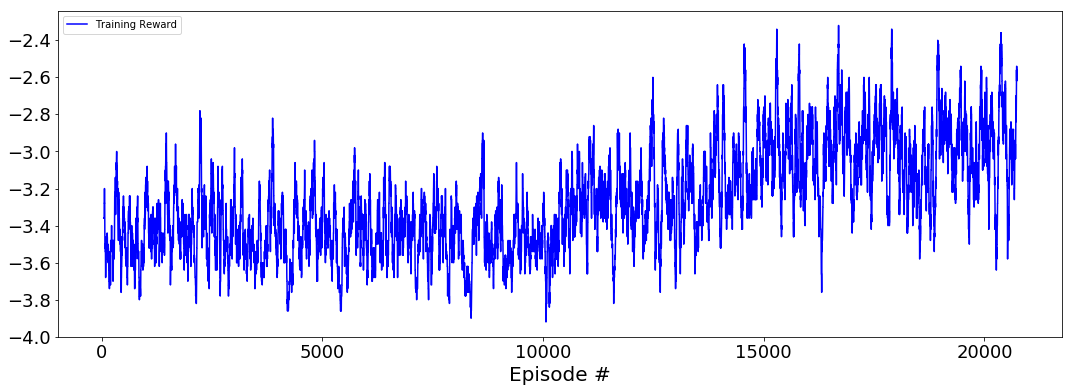

In [19]:
import pandas as pd
import matplotlib
%matplotlib inline

# csv_file has all the RL training metrics
# csv_file = "{}/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv".format(tmp_dir)
csv_file_name = "worker_0.simple_rl_graph.main_level.main_level.agent_0.csv"
key = intermediate_folder_key + "/" + csv_file_name
wait_for_s3_object(s3_bucket, key, tmp_dir)

csv_file = "{}/{}".format(tmp_dir, csv_file_name)
df = pd.read_csv(csv_file)
x_axis = 'Episode #'
y_axis_rl = 'Training Reward'
df[y_axis_rl] = df[y_axis_rl].rolling(50).mean()
ax = df.plot(x=x_axis,y=y_axis_rl, figsize=(18,6), fontsize=18, legend=True, color='b')
fig = ax.get_figure()
ax.set_xlabel(x_axis,fontsize=20)
#ax.set_ylabel(y_axis,fontsize=20)
#fig.savefig('training_reward_vs_wall_clock_time.pdf')

#### Visualize the rendered gifs
The latest gif file found in the gifs directory is displayed. You can replace the tmp.gif file below to visualize other files generated.

In [ ]:
key = intermediate_folder_key + '/gifs'
wait_for_s3_object(s3_bucket, key, tmp_dir)    
print("Copied gifs files to {}".format(tmp_dir))

glob_pattern = os.path.join("{}/*.gif".format(tmp_dir))
gifs = [file for file in glob.iglob(glob_pattern, recursive=True)]
extract_episode = lambda string: int(re.search('.*episode-(\d*)_.*', string, re.IGNORECASE).group(1))
gifs.sort(key=extract_episode)
print("GIFs found:\n{}".format("\n".join([os.path.basename(gif) for gif in gifs])))    

# visualize a specific episode
gif_index = -1 # since we want last gif
gif_filepath = gifs[gif_index]
gif_filename = os.path.basename(gif_filepath)
print("Selected GIF: {}".format(gif_filename))
os.system("mkdir -p ./src/tmp_render/ && cp {} ./src/tmp_render/{}.gif".format(gif_filepath, gif_filename))
HTML('<img src="./src/tmp_render/{}.gif">'.format(gif_filename))

### Evaluation of RL models

We use the last checkpointed model to run evaluation for the RL Agent. 

#### Load checkpointed model

Checkpointed data from the previously trained models will be passed on for evaluation / inference in the checkpoint channel. In local mode, we can simply use the local directory, whereas in the SageMaker mode, it needs to be moved to S3 first.

In [ ]:
%%time

wait_for_s3_object(s3_bucket, output_tar_key, tmp_dir)  

if not os.path.isfile("{}/output.tar.gz".format(tmp_dir)):
    raise FileNotFoundError("File output.tar.gz not found")
os.system("tar -xvzf {}/output.tar.gz -C {}".format(tmp_dir, tmp_dir))

if local_mode:
    checkpoint_dir = "{}/data/checkpoint".format(tmp_dir)
else:
    checkpoint_dir = "{}/checkpoint".format(tmp_dir)

print("Checkpoint directory {}".format(checkpoint_dir))

In [ ]:
%%time

if local_mode:
    checkpoint_path = 'file://{}'.format(checkpoint_dir)
    print("Local checkpoint file path: {}".format(checkpoint_path))
else:
    checkpoint_path = "s3://{}/{}/checkpoint/".format(s3_bucket, job_name)
    if not os.listdir(checkpoint_dir):
        raise FileNotFoundError("Checkpoint files not found under the path")
    os.system("aws s3 cp --recursive {} {}".format(checkpoint_dir, checkpoint_path))
    print("S3 checkpoint file path: {}".format(checkpoint_path))

#### Run the evaluation step

Use the checkpointed model to run the evaluation step. 

In [ ]:
estimator_eval = RLEstimator(role=role,
                             source_dir='src/',
                             dependencies = ["common/sagemaker_rl"],
                             toolkit=RLToolkit.COACH,
                             toolkit_version='0.11.0',
                             framework=RLFramework.TENSORFLOW,
                             entry_point="evaluate-coach.py",
                             train_instance_count=1,
                             train_instance_type=instance_type,
                             hyperparameters = {
                                 "RLCOACH_PRESET": "preset-tsp-easy",
                                 "evaluate_steps": 200, #max 4 episodes
                             }
                            )

estimator_eval.fit({'checkpoint': checkpoint_path})

## Medium version of TSP <a name="TSP-Medium"></a>
We make the problem much harder in this version by randomizing the location of destiations each episode. Hence, RL agent has to come up with a general strategy to navigate the grid. Parameters, states, actions, and rewards are identical to the Easy version of TSP.

### States
At each time step, our agent is aware of the following information:

1. For the Restuarant:
    1. Location (x,y coordinates)
    
2. For the Driver
    1. Location (x,y coordinates)
    2. Is driver at restaurant (yes/no)

3. For each Order: 
    1. Location (x,y coordinates)
    2. Status (Delivered or Not Delivered)
    3. Time (Time taken to deliver reach order -- incrementing until delivered)
4. Miscellaneous
    1. Time since start of episode
    2. Time remaining until end of episode (i.e. until max time)


### Actions
At each time step, our agent can take the following steps:
- Up - Move one step up in the map
- Down - Move one step down in the map
- Right - Move one step right in the map
- Left - Move one step left in the map

### Rewards
Agent gets a reward of -1 for each time step. If an order is delivered in that timestep, it gets a positive reward inversely proportional to the time taken to deliver. If all the orders are delivered and the agent is back to the restaurant, it gets an additional reward inversely proportional to time since start of episode.

## Using AWS SageMaker for RL <a name="SM-TSP-Medium"></a>

### Train the model using Python SDK/Script mode

Skipping through the basic setup, assuming you did that already for the easy version. For good results, we suggest you train for at least 1,000,000 steps. You can edit this either as a hyperparameter in the cell or directly change the preset file.

In [ ]:
%%time

# run in local mode?
local_mode = False

# create unique job name 
job_name_prefix = 'rl-tsp-medium'

In [ ]:
%%time

if local_mode:
    instance_type = 'local'
else:
    instance_type = "ml.m4.4xlarge"
    
estimator = RLEstimator(entry_point="train-coach.py",
                        source_dir='src',
                        dependencies = ["common/sagemaker_rl"],
                        toolkit=RLToolkit.COACH,
                        toolkit_version='0.11.0',
                        framework=RLFramework.TENSORFLOW,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        hyperparameters = {
                          "RLCOACH_PRESET": "preset-tsp-medium",
                        }
                    )

estimator.fit(wait=local_mode)

## Visualize, Compare with Baseline and Evaluate

You can follow the same set of code used for TSP easy version.

# Vehicle Routing Problem with Reinforcement Learning <a name="VRP-Easy"></a>

Vehicle Routing Problem (VRP) is a similar problem where the algorithm optimizes the movement of a fleet of vehicles. Our VRP formulation is a bit different, we have a delivery driver who accepts orders from customers, picks up food from a restaurant and delivers it to the customer. The driver optimizes to increase the number of successful deliveries within a time limit.

Key differences from TSP: 

- Pathing is now automatic.  Instead of choosing "left, right, up, down", now you just select your destination as your action.  The environment will get you there in the fewest steps possible.
- Since the routing/pathing is now taken care of, we add in complexity elsewhere...
- There can be more than one restaurant, each with a different type of order (e.g. Pizzas vs. Burritos).  Each order will have a different type, and you have to visit the correct restuarant to pick up an order before dropping it off.
- Drivers have a limited capacity; they cannot pick up an infinite number of orders.  Instead, they can only have (e.g. 5) orders in the car at any given time.  This means they will have to return to the restaurant(s) in between deliveries to pick up more supply.
- Orders now come in dynamically over time, rather than all being known at time zero.  Each time step, there is some probability that an order will be generated.  
- As the driver/agent, we now have the choice to fulfill an order or not -- there's no penalty associated with not accepting an order, but a potential penalty if we accept an order and fail to deliver it before Timeout.

### States
At each time step, our agent is aware of the following information:

1. For each Restuarant:
    1. Location (x,y coordinates)
    
1. For the Driver
    1. Location (x,y coordinates)
    2. Capacity (maximum # of orders you can carry, at one time, on the driver)
    3. Used Capacity (# of orders you currently carry on the driver)

1. For each Order: 
    1. Location (x,y coordinates)
    2. Status (Accepted, Not Accepted, Delivered, Not Delivered)
    3. Type (Which restuarant the order belongs to, like Pizza, or Burrito)
    4. Time (Time since order was generated)
    5. Promise (If you deliver the order by this time, you get a bonus reward)
    6. Timeout (If you deliver the order after this time, you get a penalty)

### Actions
At each time step, our agent can do ONE of the following:
- Choose a restaurant to visit (incremental step L,R,U,D, will be auto-pathed)
- Choose an order to visit (incremental step L,R,U,D, will be auto-pathed)
- Accept an order (no movement will occur)
- Do nothing

### Rewards
- Driver gets a reward of -1 for each time step. 
- If driver delivers order, get a reward proportional to the time taken to deliver (extra bonus for beating Promise time)
- If order expires (reaches Timeout), get a penalty

## Using AWS SageMaker RL <a name="SM-VRP-Easy"></a>

### Train the model using Python SDK/Script mode

Skipping through the basic setup, assuming you did that already for the easy version. For good results, we suggest a minimum of 5,000,000 steps of training.

In [ ]:
%%time

# run in local mode?
local_mode = False

# create unique job name 
job_name_prefix = 'rl-vrp-easy'

In [ ]:
%%time

if local_mode:
    instance_type = 'local'
else:
    instance_type = "ml.m4.4xlarge"
    
estimator = RLEstimator(entry_point="train-coach.py",
                        source_dir='src',
                        dependencies = ["common/sagemaker_rl"],
                        toolkit=RLToolkit.COACH,
                        toolkit_version='0.11.0',
                        framework=RLFramework.TENSORFLOW,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        hyperparameters = {
                          "RLCOACH_PRESET": "preset-vrp-easy",
                        }
                    )

estimator.fit(wait=local_mode)

## Visualize, Compare with Baseline and Evaluate

You can follow the same set of code used for TSP easy version.